This notebook was used to train the DROP dataset on BERT base model.

In [ ]:
 pip install transformers

In [ ]:
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

In [ ]:
MODEL_PATH = "bert-base-uncased"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
num_questions = 0
num_posible = 0
num_imposible = 0

In [ ]:
def get_data(path):
  with open(path, 'rb') as f:
    raw_data = json.load(f)

  contexts = []
  questions = []
  answers = []
  num_q = 0
  num_pos = 0
  num_imp = 0

  for group in list(raw_data.values()):
    context = group['passage']
    for qa in group['qa_pairs']:
      question = qa['question']
      num_q  = num_q  + 1

      if qa['answer']['number'] != "":
        num_pos += 1
        qa['is_impossible'] = False
        answer = qa['answer']['number']
        contexts.append(context.lower())
        questions.append(question.lower())
        answers.append({'text' : answer})

      # elif qa['answer']['date']["year"] != "":
      #   num_pos += 1
      #   qa['is_impossible'] = False

      #   if qa['answer']['date']['day'] != "":
      #     answer = qa['answer']['date']['day'] + " " + qa['answer']['date']['month']  + " " + qa['answer']['date']['year']

      #   if qa['answer']['date']['month'] != "":
      #     answer = qa['answer']['date']['month']  + " " + qa['answer']['date']['year']

      #   else:
      #     answer = qa['answer']['date']['year']

      #   contexts.append(context.lower())
      #   questions.append(question.lower())
      #   answers.append(answer)

      elif len(qa['answer']['spans'])!=0:
        num_pos += 1
        qa['is_impossible'] = False
        for answer in qa['answer']['spans']:
          contexts.append(context.lower())
          questions.append(question.lower())
          answers.append({'text' : answer})

      else:
        num_imp = num_imp + 1

  return num_q, num_pos, num_imp, contexts, questions, answers

In [ ]:
num_q, num_pos, num_imp, train_contexts, train_questions, train_answers = get_data('/content/drive/MyDrive/OELP_BERT/BERT_DROP/drop_dataset_train.json')
num_questions  = num_q
num_posible = num_pos
num_imposible  = num_imp

In [ ]:
print(train_questions[0:10])
print(train_answers[0:10])

['how many points did the buccaneers need to tie in the first?', 'how many field goals did the lions score?', "how long was the lion's longest field goal?", 'who caught the touchdown for the fewest yard?', 'who caught the shortest touchdown pass?', 'how many field goals were scored in the first quarter?', 'how many yards was the shortest touchdown scoring play?', 'how many touchdowns were scored in the second quarter?', 'which player scored the first points of the game for tampa bay?', 'how many yards hanson score with in the first?']
[{'text': '3'}, {'text': '2'}, {'text': '28-yard'}, {'text': 'Mike Williams'}, {'text': 'Calvin Johnson'}, {'text': '3'}, {'text': '1'}, {'text': '3'}, {'text': 'Connor Barth'}, {'text': '23'}]


In [ ]:
num_q, num_pos, num_imp, valid_contexts, valid_questions, valid_answers = get_data('/content/drive/MyDrive/OELP_BERT/BERT_DROP/drop_dataset_dev.json')
num_questions  = num_questions + num_q
num_posible = num_posible + num_pos
num_imposible = num_imposible  + num_imp

print(f"Total number of questions: {num_questions}")
print(f"Total number of Answerable questions: {num_posible}")
print(f"Total number of impossible questions: {num_imposible}")

Total number of questions: 86945
Total number of Answerable questions: 85547
Total number of impossible questions: 1398


In [ ]:
print(valid_questions[0:10])
print(valid_answers[0:10])

['who scored the first touchdown of the game?', 'how many field goals did kris brown kick?', 'which team won the game?', 'how many field goals did both teams kick in the first half?', "how many more yards was kris browns's first field goal over his second?", 'who threw the longest pass?', 'how many yards was the longest touchdown of the game?', 'how many field goals did sebastian janikowski and kris brown both score each?', "how many yards difference is there between sebastian janikowski's longest field goal and his shortest field goal?", "how many yards difference is there between kris brown's longest and shortest field goals?"]
[{'text': 'Chaz Schilens'}, {'text': '3'}, {'text': 'Raiders'}, {'text': '2'}, {'text': '29'}, {'text': 'Russell'}, {'text': '80-yard'}, {'text': '2'}, {'text': '3'}, {'text': '29'}]


In [ ]:
def add_answer_start(answers, contexts):
  for answer, context in zip(answers, contexts):
    answer['answer_start'] = context.find(answer['text'])


In [ ]:
add_answer_start(train_answers, train_contexts)
add_answer_start(valid_answers, valid_contexts)

In [ ]:
def add_answer_end(answers, contexts):
  for answer, context in zip(answers, contexts):
    answer['text'] = answer['text'].lower()
    answer['answer_end'] = answer['answer_start'] + len(answer['text'])

add_answer_end(train_answers, train_contexts)
add_answer_end(valid_answers, valid_contexts)

In [ ]:

print(f"Context: {train_contexts[0]}")
print(f"Question: {train_questions[0]}")
print(f"Answer: {train_answers[0]}")

In [ ]:
test_rec = 30
print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Answer: {valid_answers[test_rec]}")

Context:  still searching for their first win, the bengals flew to texas stadium for a week 5 interconference duel with the dallas cowboys.  in the first quarter, cincinnati trailed early as cowboys kicker nick folk got a 30-yard field goal, along with rb felix jones getting a 33-yard td run.  in the second quarter, dallas increased its lead as qb tony romo completed a 4-yard td pass to te jason witten.  the bengals would end the half with kicker shayne graham getting a 41-yard and a 31-yard field goal. in the third quarter, cincinnati tried to rally as qb carson palmer completed an 18-yard td pass to wr t. j. houshmandzadeh.  in the fourth quarter, the bengals got closer as graham got a 40-yard field goal, yet the cowboys answered with romo completing a 57-yard td pass to wr terrell owens.  cincinnati tried to come back as palmer completed a 10-yard td pass to houshmandzadeh (with a failed 2-point conversion), but dallas pulled away with romo completing a 15-yard td pass to wr patrick

1802


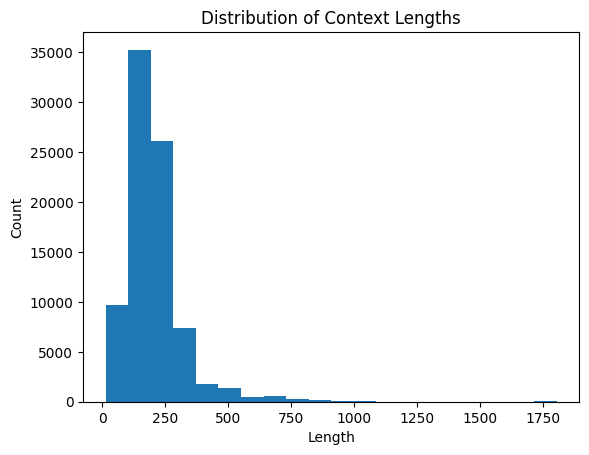

In [ ]:
token_lens = []

for txt in train_contexts:
    txt = txt.strip()
    token_lens.append(len(txt.split(' ')))


print(max(token_lens))

plt.hist(token_lens,  bins=20)
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

59
83245


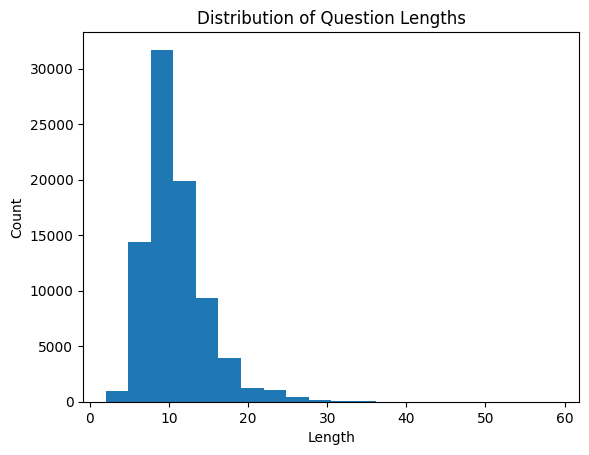

In [ ]:
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [ ]:
MAX_LENGTH = 250

In [ ]:
tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)

train_encodings_fast = tokenizerFast(train_questions, train_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings_fast = tokenizerFast(valid_questions,valid_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
type(train_encodings_fast)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['input_ids'][1]))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
83245
250


In [ ]:
print(train_encodings_fast['input_ids'][1])
print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(train_encodings_fast['input_ids'][1])))

[101, 2129, 2116, 2492, 3289, 2106, 1996, 7212, 3556, 1029, 102, 2000, 2707, 1996, 2161, 1010, 1996, 7212, 6158, 2148, 2000, 9925, 1010, 3516, 2000, 2202, 2006, 1996, 9925, 3016, 21629, 1012, 1996, 7212, 3195, 2034, 1999, 1996, 2034, 4284, 2007, 1037, 2603, 1011, 4220, 2492, 3125, 2011, 4463, 17179, 1012, 1996, 21629, 5079, 2009, 2039, 2007, 1037, 4229, 1011, 4220, 2492, 3125, 2011, 6720, 12075, 2232, 1010, 2059, 2165, 1996, 2599, 2043, 1037, 14702, 2497, 21368, 12322, 16618, 1037, 3413, 2013, 5487, 15064, 1998, 2743, 2009, 1999, 2654, 4210, 1012, 1996, 7212, 5838, 2007, 1037, 2654, 1011, 4220, 2492, 3125, 1012, 1999, 1996, 2117, 4284, 1010, 5626, 2165, 1996, 2599, 2007, 1037, 4029, 1011, 4220, 7921, 4608, 2011, 11130, 3779, 1010, 1998, 2101, 2794, 2062, 2685, 2043, 4116, 8040, 5369, 18142, 2099, 3236, 2019, 2340, 1011, 4220, 14595, 3413, 1012, 9925, 3016, 5838, 2007, 1037, 2861, 1011, 4220, 2492, 3125, 2074, 2077, 22589, 1012, 1996, 2117, 2431, 2001, 4659, 4251, 1010, 2007, 2169, 2136

In [ ]:
type(train_answers[0]['text'])
train_answers[0].keys()

dict_keys(['text', 'answer_start', 'answer_end'])

In [ ]:
def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):

            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [ ]:
test_rec=92

z,x = ret_Answer_start_and_end_train(test_rec)
print("z and x are")
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

z and x are
0 0

135444
[CLS] how many more people are there than housing units? [SEP] as of the census of 2000, there were 218, 590 people, 79, 667 households, and 60, 387 families residing in the county. the population density was 496 people per square mile ( 192 / km² ). there were 83, 146 housing units at an average density of 189 per square mile ( 73 / km² ). the racial makeup of the county was 86. 77 % race ( united states census ), 9. 27 % race ( united states census ), 0. 23 % race ( united states census ), 1. 52 % race ( united states census ), 0. 06 % race ( united states census ), 0. 69 % from race ( united states census ), and 1. 47 % from two or more races. 1. 91 % of the population were race ( united states census ) or race ( united states census ) of any race. 22. 5 % were of german people, 13. 1 % irish people, 9. 8 % italian people, 9. 2 % english, 8. 1 % " american " and 6. 0 % polish ancestry. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [ ]:
test_rec=1

z,x = ret_Answer_start_and_end_train(test_rec)
print("z and x are")
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

z and x are
0 0

2
[CLS] how many field goals did the lions score? [SEP] to start the season, the lions traveled south to tampa, florida to take on the tampa bay buccaneers. the lions scored first in the first quarter with a 23 - yard field goal by jason hanson. the buccaneers tied it up with a 38 - yard field goal by connor barth, then took the lead when aqib talib intercepted a pass from matthew stafford and ran it in 28 yards. the lions responded with a 28 - yard field goal. in the second quarter, detroit took the lead with a 36 - yard touchdown catch by calvin johnson, and later added more points when tony scheffler caught an 11 - yard td pass. tampa bay responded with a 31 - yard field goal just before halftime. the second half was relatively quiet, with each team only scoring one touchdown. first, detroit's calvin johnson caught a 1 - yard pass in the third quarter. the game's final points came when mike williams of tampa bay caught a 5 - yard pass. the lions won their regular se

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
83245


In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
    s, e = ret_Answer_start_and_end_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

37029


In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
83245


In [ ]:
test_rec = 1
print(train_encodings_fast['start_positions'][test_rec])
print(train_encodings_fast['end_positions'][test_rec])
predict_answer_tokens = train_encodings_fast.input_ids[test_rec][train_encodings_fast['start_positions'][test_rec] : train_encodings_fast['end_positions'][test_rec]]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

0
0

2
[CLS] how many field goals did the lions score? [SEP] to start the season, the lions traveled south to tampa, florida to take on the tampa bay buccaneers. the lions scored first in the first quarter with a 23 - yard field goal by jason hanson. the buccaneers tied it up with a 38 - yard field goal by connor barth, then took the lead when aqib talib intercepted a pass from matthew stafford and ran it in 28 yards. the lions responded with a 28 - yard field goal. in the second quarter, detroit took the lead with a 36 - yard touchdown catch by calvin johnson, and later added more points when tony scheffler caught an 11 - yard td pass. tampa bay responded with a 31 - yard field goal just before halftime. the second half was relatively quiet, with each team only scoring one touchdown. first, detroit's calvin johnson caught a 1 - yard pass in the third quarter. the game's final points came when mike williams of tampa bay caught a 5 - yard pass. the lions won their regular season opener 

In [ ]:
def ret_Answer_start_and_end_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(valid_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != valid_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(valid_encodings_fast['input_ids']) ):
    s, e = ret_Answer_start_and_end_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


valid_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

5008


In [ ]:
test_rec=2

z,x = ret_Answer_start_and_end_valid(test_rec)

predict_answer_tokens = valid_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(valid_answers[test_rec]['text'])
print(tokenizerFast.decode(valid_encodings_fast['input_ids'][test_rec]))

raiders
raiders
[CLS] which team won the game? [SEP] hoping to rebound from their loss to the patriots, the raiders stayed at home for a week 16 duel with the houston texans. oakland would get the early lead in the first quarter as quarterback jamarcus russell completed a 20 - yard touchdown pass to rookie wide receiver chaz schilens. the texans would respond with fullback vonta leach getting a 1 - yard touchdown run, yet the raiders would answer with kicker sebastian janikowski getting a 33 - yard and a 30 - yard field goal. houston would tie the game in the second quarter with kicker kris brown getting a 53 - yard and a 24 - yard field goal. oakland would take the lead in the third quarter with wide receiver johnnie lee higgins catching a 29 - yard touchdown pass from russell, followed up by an 80 - yard punt return for a touchdown. the texans tried to rally in the fourth quarter as brown nailed a 40 - yard field goal, yet the raiders'defense would shut down any possible attempt. [SE

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['start_positions']))
print(len(train_encodings_fast['end_positions']))
print(len(valid_encodings_fast['input_ids']))
print(len(valid_encodings_fast['start_positions']))
print(len(valid_encodings_fast['end_positions']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
83245
83245
83245
10297
10297
10297


In [ ]:
tokenizerFast.decode(train_encodings_fast['input_ids'][0])

"[CLS] how many points did the buccaneers need to tie in the first? [SEP] to start the season, the lions traveled south to tampa, florida to take on the tampa bay buccaneers. the lions scored first in the first quarter with a 23 - yard field goal by jason hanson. the buccaneers tied it up with a 38 - yard field goal by connor barth, then took the lead when aqib talib intercepted a pass from matthew stafford and ran it in 28 yards. the lions responded with a 28 - yard field goal. in the second quarter, detroit took the lead with a 36 - yard touchdown catch by calvin johnson, and later added more points when tony scheffler caught an 11 - yard td pass. tampa bay responded with a 31 - yard field goal just before halftime. the second half was relatively quiet, with each team only scoring one touchdown. first, detroit's calvin johnson caught a 1 - yard pass in the third quarter. the game's final points came when mike williams of tampa bay caught a 5 - yard pass. the lions won their regular s

In [ ]:
test_row= 0
print(train_contexts[test_row][train_answers[test_row]['answer_start']:train_answers[test_row]['answer_end']])

3


In [ ]:
answer_start_index = 0
answer_end_index = 100

predict_answer_tokens = train_encodings_fast.input_ids[0][answer_start_index : answer_end_index]
tokenizerFast.decode(predict_answer_tokens)

'[CLS] how many points did the buccaneers need to tie in the first? [SEP] to start the season, the lions traveled south to tampa, florida to take on the tampa bay buccaneers. the lions scored first in the first quarter with a 23 - yard field goal by jason hanson. the buccaneers tied it up with a 38 - yard field goal by connor barth, then took the lead when aqib talib intercepted a pass from matthew stafford and ran it in 28 yards. the lions responded with a'

In [ ]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
train_dataset = InputDataset(train_encodings_fast)
valid_dataset = InputDataset(valid_encodings_fast)

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=32)

In [ ]:
print(len(train_dataset))
print(train_dataset[0].keys())

83245
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])


In [ ]:
bert_model = BertModel.from_pretrained(MODEL_PATH)
class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)
        logits = self.linear_relu_stack(out)

        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
model = QAModel()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

In [ ]:
def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):

    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end

    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)

    nll = nn.NLLLoss()

    fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)

    return ((fl_start + fl_end)/2)

In [ ]:
optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
        loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1)
        losses.append(loss.item())
        loss.backward()
        optim.step()
        #print(out_start)

        # for iter in range(16):
        #   print(tokenizerFast.decode(input_ids[iter]))

        # print(out_start.size())
        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)
        # print("\n")
        #print((type(start_positions)))
        #print(type(start_pred))

        # for iter in range(16):
        #   print("pred")
        #   print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[iter][start_pred[iter] : end_pred[iter]])))
        #   print("true ans")
        #   print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[iter][start_positions[iter] : end_positions[iter]])))

        #print(start_pred)
        #print(start_positions)

        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())

        #print(f"acc1 is {acc[-2]} acc2 is {acc[-1]}")
        # print("\n")

        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [ ]:
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)

            out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)

            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
        ret_acc = sum(acc)/len(acc)
        ret_loss = 0
    return(ret_acc)

In [ ]:
EPOCHS = 4

model.to(device)

for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    val_acc = eval_model(model, valid_data_loader)
    print(f"Validation Accuracy: {val_acc}")

Running Epoch : 100%|██████████| 5203/5203 [1:04:34<00:00,  1.34it/s]


Train Accuracy: 0.5743057814305181      Train Loss: 1.2205998959184816


Running Evaluation: 100%|██████████| 322/322 [02:36<00:00,  2.06it/s]


Validation Accuracy: 0.6452503881839492


Running Epoch : 100%|██████████| 5203/5203 [1:04:38<00:00,  1.34it/s]


Train Accuracy: 0.6367203092921039      Train Loss: 0.8697809446477762


Running Evaluation: 100%|██████████| 322/322 [02:36<00:00,  2.06it/s]


Validation Accuracy: 0.6755784161342597


Running Epoch : 100%|██████████| 5203/5203 [1:04:37<00:00,  1.34it/s]


Train Accuracy: 0.6735514089531013      Train Loss: 0.7208052938966918


Running Evaluation: 100%|██████████| 322/322 [02:36<00:00,  2.06it/s]


Validation Accuracy: 0.6834879658237007


Running Epoch : 100%|██████████| 5203/5203 [1:04:39<00:00,  1.34it/s]


Train Accuracy: 0.7001498765540357      Train Loss: 0.6073969036810403


Running Evaluation: 100%|██████████| 322/322 [02:36<00:00,  2.05it/s]

Validation Accuracy: 0.6854289596125206


In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
scheduler.get_last_lr()

[1.3122e-05]

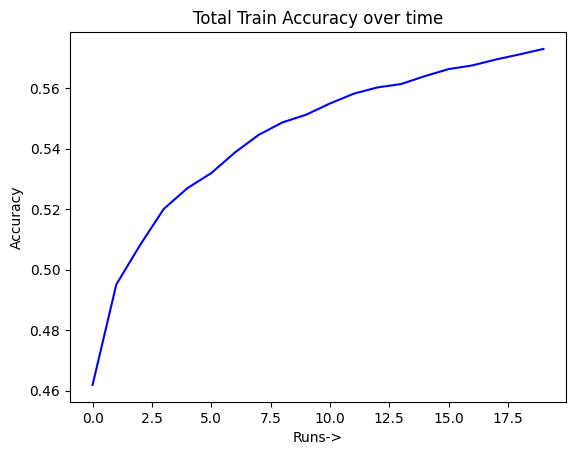

In [ ]:
plt.plot(total_acc, color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.title("Total Train Accuracy over time");

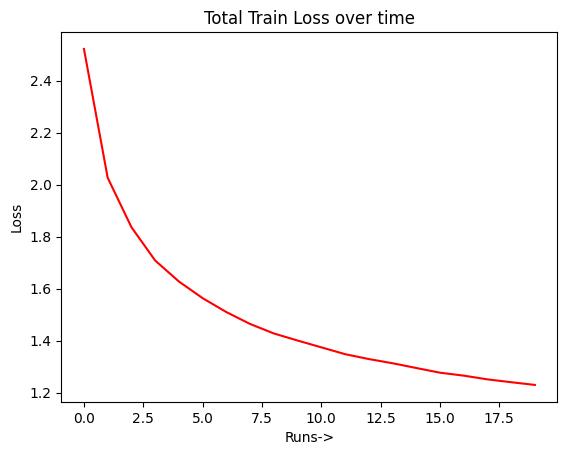

In [ ]:
plt.plot(total_loss, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

In [ ]:
def get_answer(question, context):
    inputs = tokenizerFast.encode_plus(question, context, return_tensors='pt').to(device)
    with torch.no_grad():
        output_start, output_end = model(**inputs)

        answer_start = torch.argmax(output_start)
        answer_end = torch.argmax(output_end)

        answer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

        return(answer)

In [ ]:
test_rec = 0

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context:  hoping to rebound from their loss to the patriots, the raiders stayed at home for a week 16 duel with the houston texans.  oakland would get the early lead in the first quarter as quarterback jamarcus russell completed a 20-yard touchdown pass to rookie wide receiver chaz schilens.  the texans would respond with fullback vonta leach getting a 1-yard touchdown run, yet the raiders would answer with kicker sebastian janikowski getting a 33-yard and a 30-yard field goal.  houston would tie the game in the second quarter with kicker kris brown getting a 53-yard and a 24-yard field goal. oakland would take the lead in the third quarter with wide receiver johnnie lee higgins catching a 29-yard touchdown pass from russell, followed up by an 80-yard punt return for a touchdown.  the texans tried to rally in the fourth quarter as brown nailed a 40-yard field goal, yet the raiders' defense would shut down any possible attempt.
Question: who scored the first touchdown of the game?
Expec

In [ ]:
test_rec = 15

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context:  hoping to rebound from their loss to the patriots, the raiders stayed at home for a week 16 duel with the houston texans.  oakland would get the early lead in the first quarter as quarterback jamarcus russell completed a 20-yard touchdown pass to rookie wide receiver chaz schilens.  the texans would respond with fullback vonta leach getting a 1-yard touchdown run, yet the raiders would answer with kicker sebastian janikowski getting a 33-yard and a 30-yard field goal.  houston would tie the game in the second quarter with kicker kris brown getting a 53-yard and a 24-yard field goal. oakland would take the lead in the third quarter with wide receiver johnnie lee higgins catching a 29-yard touchdown pass from russell, followed up by an 80-yard punt return for a touchdown.  the texans tried to rally in the fourth quarter as brown nailed a 40-yard field goal, yet the raiders' defense would shut down any possible attempt.
Question: how many field goals were scored in the game?
Exp

In [ ]:
test_rec = 28

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context:  still searching for their first win, the bengals flew to texas stadium for a week 5 interconference duel with the dallas cowboys.  in the first quarter, cincinnati trailed early as cowboys kicker nick folk got a 30-yard field goal, along with rb felix jones getting a 33-yard td run.  in the second quarter, dallas increased its lead as qb tony romo completed a 4-yard td pass to te jason witten.  the bengals would end the half with kicker shayne graham getting a 41-yard and a 31-yard field goal. in the third quarter, cincinnati tried to rally as qb carson palmer completed an 18-yard td pass to wr t. j. houshmandzadeh.  in the fourth quarter, the bengals got closer as graham got a 40-yard field goal, yet the cowboys answered with romo completing a 57-yard td pass to wr terrell owens.  cincinnati tried to come back as palmer completed a 10-yard td pass to houshmandzadeh (with a failed 2-point conversion), but dallas pulled away with romo completing a 15-yard td pass to wr patrick

In [ ]:
test_rec = 2000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: bangkok is one of the worlds top tourist destinations. of 162 cities worldwide, mastercard ranked bangkok as the top destination city by international visitor arrivals in its global destination cities index 2018, ahead of london, with just over 20 million overnight visitors in 2017. this was a repeat of its 2017 ranking (for 2016). euromonitor international ranked bangkok fourth in its top city destinations ranking for 2016. bangkok was also named "worlds best city" by travel + leisure magazines survey of its readers for four consecutive years, from 2010 to 2013. as the main gateway through which visitors arrive in thailand, bangkok is visited by the majority of international tourists to the country. domestic tourism is also prominent. the department of tourism recorded 26,861,095 thai and 11,361,808 foreign visitors to bangkok in 2010. lodgings were made by 15,031,244 guests, who occupied 49.9 percent of the citys 86,687 hotel rooms. bangkok also topped the list as the worlds

In [ ]:
test_rec = 4000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the 2010 united states census reported that huntington beach had a population of 189,992. the population density was 5,959.1 people per square mile (2,300.8/km²). the racial makeup of huntington beach was 145,661 (76.7%) white (u.s. census), 1,813 (1.0%) african american (u.s. census), 992 (0.5%) native american (u.s. census), 21,070 (11.1%) asian (u.s. census), 635 (0.3%) pacific islander (u.s. census), 11,193 (5.9%) from race (united states census), and 8,628 (4.5%) from two or more races. hispanic (u.s. census) or latino (u.s. census) of any race were 32,411 persons (17.1%). non-hispanic whites were 67.2% of the population in 2010, compared to 90.8% in 1970.
Question: what two ethnic groups had the highest populations in huntington beach in 2010?
Expected Answer: {'text': 'white', 'answer_start': -1, 'answer_end': 4}
Predicted Answer: asian ( u. s. census ), 635 ( 0. 3 % ) pacific islander


In [ ]:
context = "I am Utsav Patel. I just completed my fine-tuning of the BERT base uncased model. I am glad that it works after 5 attempts."
question = "How many attempts did it take to fine-tune ?"
print(f"Predicted Answer: {get_answer(question, context)}")

Predicted Answer: 


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/OELP_BERT//OELP_DROP.hdf5')